# Assignment 6 - Exercise 4
## Due June 11th at 14:00

Please note: 

- Read the instructions in the exercise PDF and in this notebook carefully.
- Add your solutions *only* at `YOUR CODE HERE`/`YOUR ANSWER HERE` and remove the corresponding `raise NotImplementedError()`.
- Do not chance the provided code and text, if not stated.
- Do not *add* or *delete* cells.
- Do not `import` additional functionality. 
- Before submitting: Please make sure, that your notebook can be executed from top to bottom `Menu -> Kernel -> Restart & Run all`. 

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
from tqdm import tqdm

#  Hide warnings of LinearSVC, LogisticRegression
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=ConvergenceWarning)

In [2]:
df = pd.read_csv('cvtrain.csv')
X_train, y_train = df.drop(columns='y').to_numpy(), df[['y']].to_numpy().flatten()

In [3]:
df = pd.read_csv('cvtest.csv')
X_test, y_test = df.drop(columns='y').to_numpy(), df[['y']].to_numpy().flatten()

In [4]:
# let's have a look at these folds
k_folds = [2, 3, 5, 10]

In [5]:
# we want to choose among these hyperparameters
parameters = {'C': np.logspace(-4, 4, num=20)}

# a) Validation

In [6]:
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import GridSearchCV

In [7]:
best_test_acc = 0

for k in k_folds:
    clf=GridSearchCV(LogisticRegression(penalty="l2"), parameters,
                     cv=ShuffleSplit(train_size=(k-1)/k, random_state=0))
    
    clf.fit(X_train, y_train)
    test_acc = clf.score(X_test, y_test)
    
    print(f"k: {k:2d} | Best params: {clf.best_params_} | Val. score: {clf.best_score_:.4f} | Test score: {test_acc:.4f}")

    if best_test_acc < test_acc:
        best_test_acc = test_acc
        best_k = k
        
print()
print(f"The best k is {best_k}, and the best test score is {best_test_acc:.4f}")

k:  2 | Best params: {'C': 11.288378916846883} | Val. score: 0.8155 | Test score: 0.8259
k:  3 | Best params: {'C': 0.23357214690901212} | Val. score: 0.8396 | Test score: 0.8263
k:  5 | Best params: {'C': 0.23357214690901212} | Val. score: 0.8450 | Test score: 0.8263
k: 10 | Best params: {'C': 0.23357214690901212} | Val. score: 0.8450 | Test score: 0.8263

The best k is 3, and the best test score is 0.8263


# b) Mean and variance introduced by validation

In [8]:
from sklearn.model_selection import ShuffleSplit

In [9]:
# if you use the data structure
# val_acc = [[results off all replications with k=2], ..., [results off all replications with k=10]]
# the violin plots below will work automatically
val_acc = [[] for k in k_folds]
test_acc = [[] for k in k_folds]

for idx, k in enumerate(k_folds):
    n = int(len(X_train) * (k-1) / k)
    
    ss = ShuffleSplit(n_splits=30, train_size=(k-1) / k, random_state=0)
    
    for train_index, val_index in ss.split(X_train):
        xtr = X_train[train_index, :]
        xvl = X_train[val_index, :]
        
        ytr = y_train[train_index]
        yvl = y_train[val_index]
        
        clf = LogisticRegression(penalty="l2").fit(xtr, ytr)
        
        train_score = clf.score(xtr, ytr)
        val_score = clf.score(xvl, yvl)
        test_score = clf.score(X_test, y_test)
        
        val_acc[idx].append(val_score)
        test_acc[idx].append(test_score)
        
#         print(f"k: {k:2d} |  Train score: {train_score:.4f} | Val. score: {val_score:.4f} | Test score: {test_score:.4f}")
        
#     print()

In [10]:
for idx, k in enumerate(k_folds):
    print(f'k={k} mean val={np.mean(val_acc[idx]):.4f} ({np.std(val_acc[idx]):.4f}) \
    mean test={np.mean(test_acc[idx]):.4f} ({np.std(test_acc[idx]):.4f})')

k=2 mean val=0.8142 (0.0213)     mean test=0.8165 (0.0058)
k=3 mean val=0.8264 (0.0293)     mean test=0.8208 (0.0030)
k=5 mean val=0.8321 (0.0386)     mean test=0.8234 (0.0022)
k=10 mean val=0.8467 (0.0664)     mean test=0.8248 (0.0013)


### Violin plots offer a nice way to visualize the distributions

In [11]:
def set_axis_style(ax, labels):
    ax.get_xaxis().set_tick_params(direction='out')
    ax.xaxis.set_ticks_position('bottom')
    ax.set_xticks(np.arange(1, len(labels) + 1))
    ax.set_xticklabels(labels)
    ax.set_xlim(0.25, len(labels) + 0.75)
    ax.set_xlabel('number of folds k')

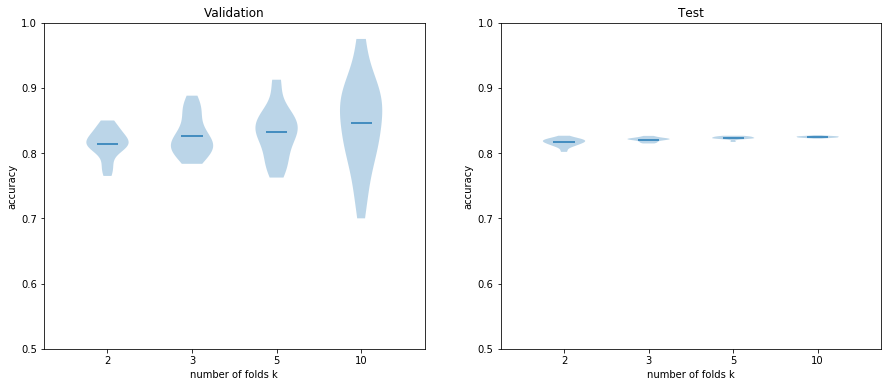

In [12]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))
ax[0].violinplot(val_acc, showmeans=True, showextrema=False)
ax[0].set_ylim([0.5, 1])
ax[0].set_title('Validation')
ax[0].set_ylabel('accuracy')
ax[1].violinplot(test_acc, showmeans=True, showextrema=False)
ax[1].set_ylim([0.5, 1])
ax[1].set_title('Test')
ax[1].set_ylabel('accuracy')
set_axis_style(ax[0], k_folds)
set_axis_style(ax[1], k_folds)

# c) Mean and variance introduced by cross-validation

In [13]:
from sklearn.model_selection import KFold

In [14]:
val_acc = [[] for k in k_folds]
test_acc = [[] for k in k_folds]

for idx, k in enumerate(k_folds):
    kf = KFold(n_splits=k, shuffle=True)
    ss = ShuffleSplit(n_splits=30)

    for _ in range(30):

        for train_index, val_index in kf.split(X_train):
            xtr = X_train[train_index, :]
            xvl = X_train[val_index, :]

            ytr = y_train[train_index]
            yvl = y_train[val_index]

            clf = LogisticRegression(penalty="l2").fit(xtr, ytr)

            train_score = clf.score(xtr, ytr)
            val_score = clf.score(xvl, yvl)
            test_score = clf.score(X_test, y_test)

            val_acc[idx].append(val_score)
            test_acc[idx].append(test_score)

#             print(f"k: {k:2d} |  Train score: {train_score:.4f} | Val. score: {val_score:.4f} | Test score: {test_score:.4f}")

#     print()

In [15]:
for idx, k in enumerate(k_folds):
    print(f'k={k} mean val={np.mean(val_acc[idx]):.4f} ({np.std(val_acc[idx]):.4f}) \
    mean test={np.mean(test_acc[idx]):.4f} ({np.std(test_acc[idx]):.4f})')

k=2 mean val=0.8208 (0.0201)     mean test=0.8192 (0.0040)
k=3 mean val=0.8228 (0.0281)     mean test=0.8218 (0.0027)
k=5 mean val=0.8246 (0.0387)     mean test=0.8239 (0.0020)
k=10 mean val=0.8313 (0.0576)     mean test=0.8250 (0.0013)


### The advantage of cross-validation becomes clear when we look at violin plots

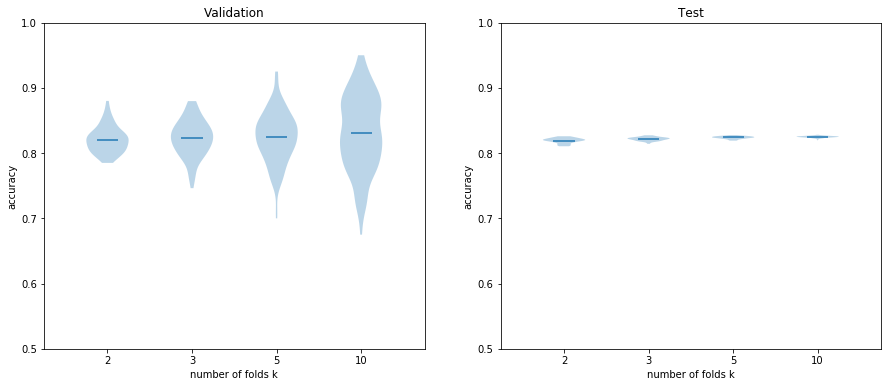

In [16]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))
ax[0].violinplot(val_acc, showmeans=True, showextrema=False)
ax[0].set_ylim([0.5, 1])
ax[0].set_title('Validation')
ax[0].set_ylabel('accuracy')
ax[1].violinplot(test_acc, showmeans=True, showextrema=False)
ax[1].set_ylim([0.5, 1])
ax[1].set_title('Test')
ax[1].set_ylabel('accuracy')
set_axis_style(ax[0], k_folds)
set_axis_style(ax[1], k_folds)

# d) How would you describe the influence of the parameter k in this example? 

<font color="blue">The influence of the parameter $k$ is not much significant since the mean test error ranges from 81.78% to 82.50%.</font>

# e)  Is it fair to directly compare the procedures from b) and c)?  Argue in terms of computational costs:  How many models does each method need to train?

<font color="blue">The method from (c) needs to train $k$ times more models than the method from (b).</font>

# f) For leave-one-out, what is the variance due to the splitting of data? In this example, does leave-one-out perform better or worse than the best k found in c)?

In [17]:
from sklearn.model_selection import LeaveOneOut

In [18]:
val_acc = []
test_acc = []

loo = LeaveOneOut()

for train_index, test_index in loo.split(X_train):
    xtr = X_train[train_index, :]
    xvl = X_train[val_index, :]

    ytr = y_train[train_index]
    yvl = y_train[val_index]

    clf = LogisticRegression(penalty="l2").fit(xtr, ytr)

    train_score = clf.score(xtr, ytr)
    val_score = clf.score(xvl, yvl)
    test_score = clf.score(X_test, y_test)

    val_acc.append(val_score)
    test_acc.append(test_score)

print(f"Val. score mean: {np.mean(val_acc):.4f} | Val. score std: {np.std(val_acc):.6f}")
print(f"Test score mean: {np.mean(test_acc):.4f} | Test score std: {np.std(test_acc):.6f}")

Val. score mean: 0.8744 | Val. score std: 0.003708
Test score mean: 0.8260 | Test score std: 0.000243


<font color="blue">The variance due to the splitting of data is smaller than the variance for smaller number of $k$ since the LOOCV has more samples for the performance of the model in terms of accuracy. Furthermore, the LOOCV has comparatively similar performance to the best $k$ found in (c) (82.60% vs. 82.50%).
</font>